I made this notebook in models/research/object_detection folder and then moved it to another directory. So, some paths may be broken.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
import xml.etree.ElementTree as ET
import glob

In [3]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

Here are the imports from the object detection module.

In [4]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

In [5]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

Generate a dict to find COCO id for Pascal VOC class name.

In [9]:
category_num = {}
for cat in categories:
    name = cat['name']
    cat_num = cat['id']
    category_num[name] = cat_num

In [19]:
category_num

{'airplane': 5,
 'apple': 53,
 'backpack': 27,
 'banana': 52,
 'baseball bat': 39,
 'baseball glove': 40,
 'bear': 23,
 'bed': 65,
 'bench': 15,
 'bicycle': 2,
 'bird': 16,
 'boat': 9,
 'book': 84,
 'bottle': 44,
 'bowl': 51,
 'broccoli': 56,
 'bus': 6,
 'cake': 61,
 'car': 3,
 'carrot': 57,
 'cat': 17,
 'cell phone': 77,
 'chair': 62,
 'clock': 85,
 'couch': 63,
 'cow': 21,
 'cup': 47,
 'dining table': 67,
 'dog': 18,
 'donut': 60,
 'elephant': 22,
 'fire hydrant': 11,
 'fork': 48,
 'frisbee': 34,
 'giraffe': 25,
 'hair drier': 89,
 'handbag': 31,
 'horse': 19,
 'hot dog': 58,
 'keyboard': 76,
 'kite': 38,
 'knife': 49,
 'laptop': 73,
 'microwave': 78,
 'motorcycle': 4,
 'mouse': 74,
 'orange': 55,
 'oven': 79,
 'parking meter': 14,
 'person': 1,
 'pizza': 59,
 'potted plant': 64,
 'refrigerator': 82,
 'remote': 75,
 'sandwich': 54,
 'scissors': 87,
 'sheep': 20,
 'sink': 81,
 'skateboard': 41,
 'skis': 35,
 'snowboard': 36,
 'spoon': 50,
 'sports ball': 37,
 'stop sign': 13,
 'suitca

In [20]:
category_num['diningtable'] = category_num['dining table']

## Helper functions

In [10]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

My XML knowledge is far from perfect. Please, don't judge me!

In [13]:
def objects_from_xml(image_path):

    xml_path = image_path.replace("JPEGImages", "Annotations").replace("jpg", "xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []

    size = {}
    for child in root.iter('size'):
        for grandchild in child:
            size[grandchild.tag] = int(grandchild.text)

    for cur_object in root.findall('object'):
        
        obj_dict = {}
        name = [t.text for t in cur_object.iter('name')][0]
        if name in category_num.keys():
            obj_dict['class'] = category_num[name]
        else:
            
        obj_dict['box'] = []

        for child in cur_object.iter('bndbox'):
            for grandchild in child:
                coord = float(grandchild.text)
                
                # normalize coordinates
                if grandchild.tag[0] == 'x':
                    coord /= size['width']
                elif grandchild.tag[0] == 'y':
                    coord /= size['height']
                obj_dict['box'].append(coord)
                
            # reorder to match model format
            obj_dict['box'][0], obj_dict['box'][-1] = obj_dict['box'][-1], obj_dict['box'][0]
        
        objects.append(obj_dict)
        
    return objects

In [14]:
def objects_from_model(boxes, scores, classes, num, SCORE_THRESHOLD=0.5):
    boxes, scores, classes, num = boxes[0], scores[0], classes[0], num[0]
    
    objects = []
    
    for i in range(int(num)):
        if scores[i] > SCORE_THRESHOLD:
            obj_dict = {}
            obj_dict['class'] = int(classes[i])
            obj_dict['box'] = boxes[i].tolist()
            objects.append(obj_dict)
            
    return objects

In [15]:
def area(y_min, x_min, y_max, x_max):
    return (y_max - y_min) * (x_max - x_min)

In [16]:
def IoU(obj1, obj2):
    y_min_1, x_min_1, y_max_1, x_max_1 = obj1['box']
    y_min_2, x_min_2, y_max_2, x_max_2 = obj2['box']
    
    if y_max_1 <= y_min_2 or y_max_2 <= y_min_1 or x_max_1 <= x_min_2 or x_max_2 <= x_min_1:
        return 0
    
    y_min_in, y_max_in = sorted([y_min_1, y_max_1, y_min_2, y_max_2])[1:3]
    x_min_in, x_max_in = sorted([x_min_1, x_max_1, x_min_2, x_max_2])[1:3]
    
    box_in = [y_min_in, x_min_in, y_max_in, x_max_in]
    
    area_in = area(*box_in)
    area_union = area(*obj1['box']) + area(*obj2['box']) - area_in
    
    return area_in / area_union

# Detection

In [11]:
TEST_IMAGE_PATHS = glob.glob("/home/margarita/AU/dl_course/seminar_4/VOC2012/JPEGImages/*")

In [12]:
len(TEST_IMAGE_PATHS)

16135

10_20_30_40_70_170_180_220_230_290_300_310_320_410_420_450_510_520_530_540_550_600_630_650_670_730_740_760_770_850_880_950_1010_1020_1070_1080_1110_1140_1170_1200_1210_1340_1350_1380_1410_1450_1460_1470_1490_1570_1600_1620_1650_1660_1680_1710_1720_1770_1800_1820_1870_1880_1900_1920_1960_1970_1980_2010_2020_2050_2120_2170_2220_2280_2340_2410_2430_2460_2470_2510_2520_2540_2550_2600_2630_2640_2660_2680_2710_2720_2750_2790_2800_2830_2840_2860_2870_3000_3050_3070_3100_3120_3150_3160_3170_3190_3230_3250_3260_3270_3300_3360_3370_3390_3450_3460_3530_3560_3570_3580_3610_3670_3700_3770_3780_3800_3830_3840_3850_3870_3900_3930_3940_3980_4090_4120_4140_4210_4220_4280_4310_4330_4340_4390_4410_4430_4460_4470_4480_4520_4550_4560_4570_4590_4600_4620_4630_4650_4670_4750_4780_4790_4800_4970_4990_5000_5010_5030_5040_5070_5080_5090_5130_5160_5250_5260_5300_5310_5330_5340_5350_5380_5450_5470_5530_5550_5560_5600_5610_5620_5660_5670_5710_5740_5750_5760_5790_5800_5810_5850_5920_5930_5990_6060_6080_6090_6100_61

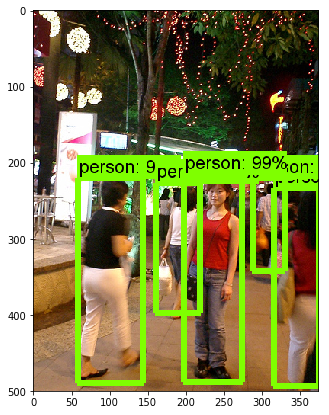

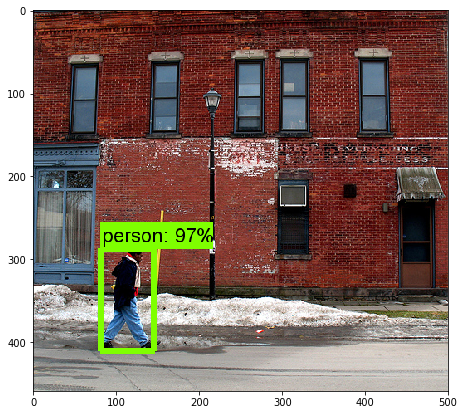

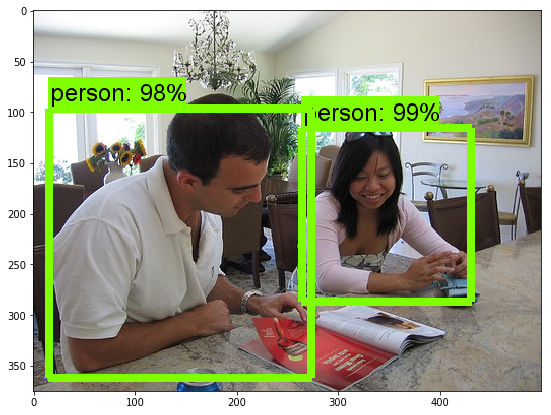

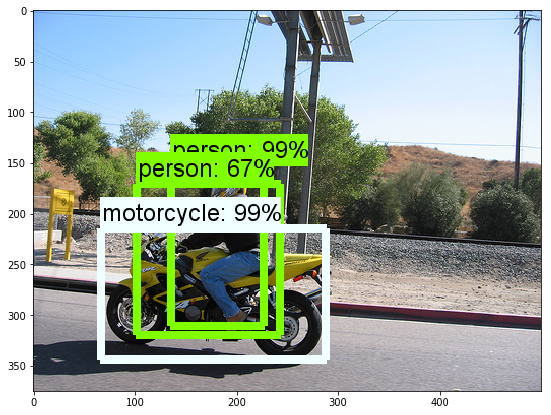

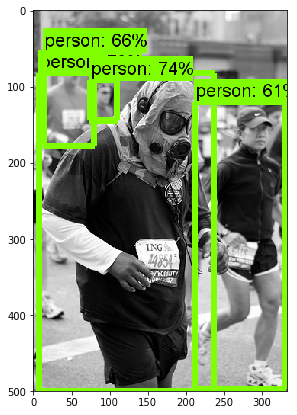

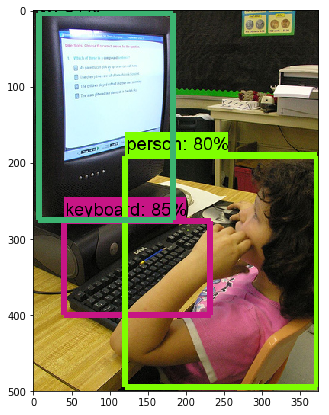

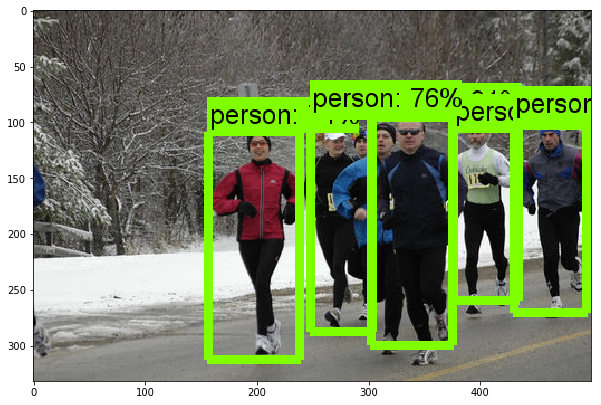

In [22]:
true_pred = 0
num_pred = 0
IoU_sum = 0

IoU_THRESHOLD = 0.5

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for i in range(len(TEST_IMAGE_PATHS)):
            image_path = TEST_IMAGE_PATHS[i]
            
            # Not all images have annotation in the data which I downloaded. So let's skip such images.
            try:
                real_objects = objects_from_xml(image_path)  
            except FileNotFoundError:
                continue
            
            # aka 'progress bar'
            if (i % 10 == 0):
                print(i, end='_')
                
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            predicted_objects = objects_from_model(boxes, scores, classes, num)
            
            for r_obj in real_objects:
                for pred_obj in predicted_objects:
                    cur_IoU = IoU(r_obj, pred_obj)
                    if cur_IoU < IoU_THRESHOLD:
                        continue
                    
                    IoU_sum += cur_IoU
                    num_pred += 1
                    if r_obj['class'] == pred_obj['class']:
                        true_pred += 1
                    
            if i < 15:
                # Visualization of the results of a detection for some first images (if they have annotation!)
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=8)
                plt.figure(figsize=(10, 7))
                plt.imshow(image_np)
                        
print('\n')
print('Average IoU:', IoU_sum / num_pred)
print('Accuracy:', true_pred / num_pred)